# Plot heatmap and logo

## Setup

In [ ]:
#| output: False
!pip install git+https://github.com/sky1ove/katlas.git -q

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from katlas.core import *
from katlas.plot import *

from scipy.stats import spearmanr, pearsonr

import os
from PIL import Image
from tqdm import tqdm


In [ ]:
def plot_count(df_k,title):
    # Get value counts
    source_counts = df_k.source.replace({'pplus':'PP','large_scale':'LS'}).value_counts()
    plt.figure(figsize=(7,1))

    source_counts.plot(kind='barh', stacked=True, color=['darkred', 'darkblue'])
    # Annotate with the actual values
    for index, value in enumerate(source_counts):
        plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')

    plt.xlabel('Count')
    plt.title(title)

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

## Load data

In [ ]:
df = Data.get_ks_dataset()

In [ ]:
info = Data.get_kinase_info_full().query('pseudo==0')

In [ ]:
# It only contains kinase on the tree
cnt = df.kinase_paper.value_counts()

In [ ]:
cnt = cnt[cnt>100]

## Heatmap & logo

One example

  0%|          | 0/289 [00:00<?, ?it/s]

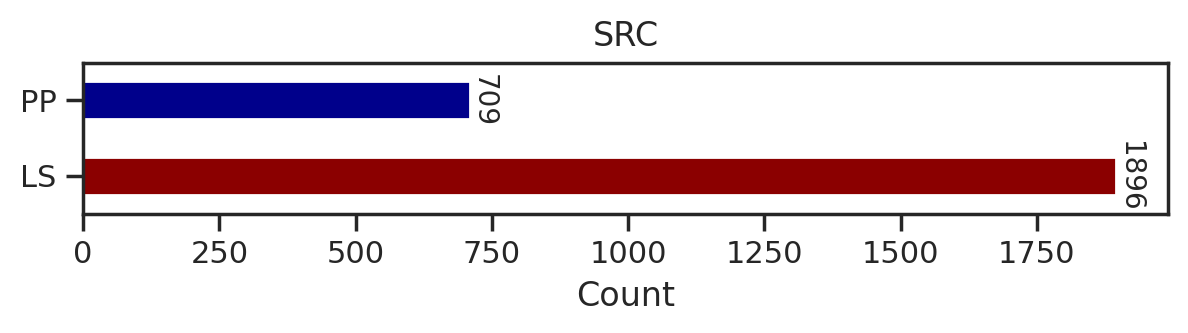

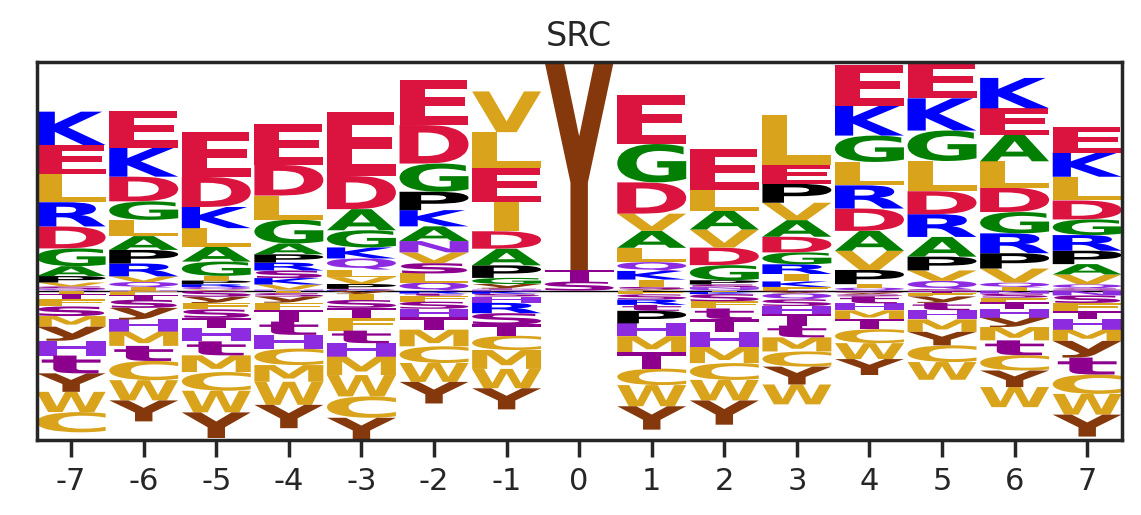

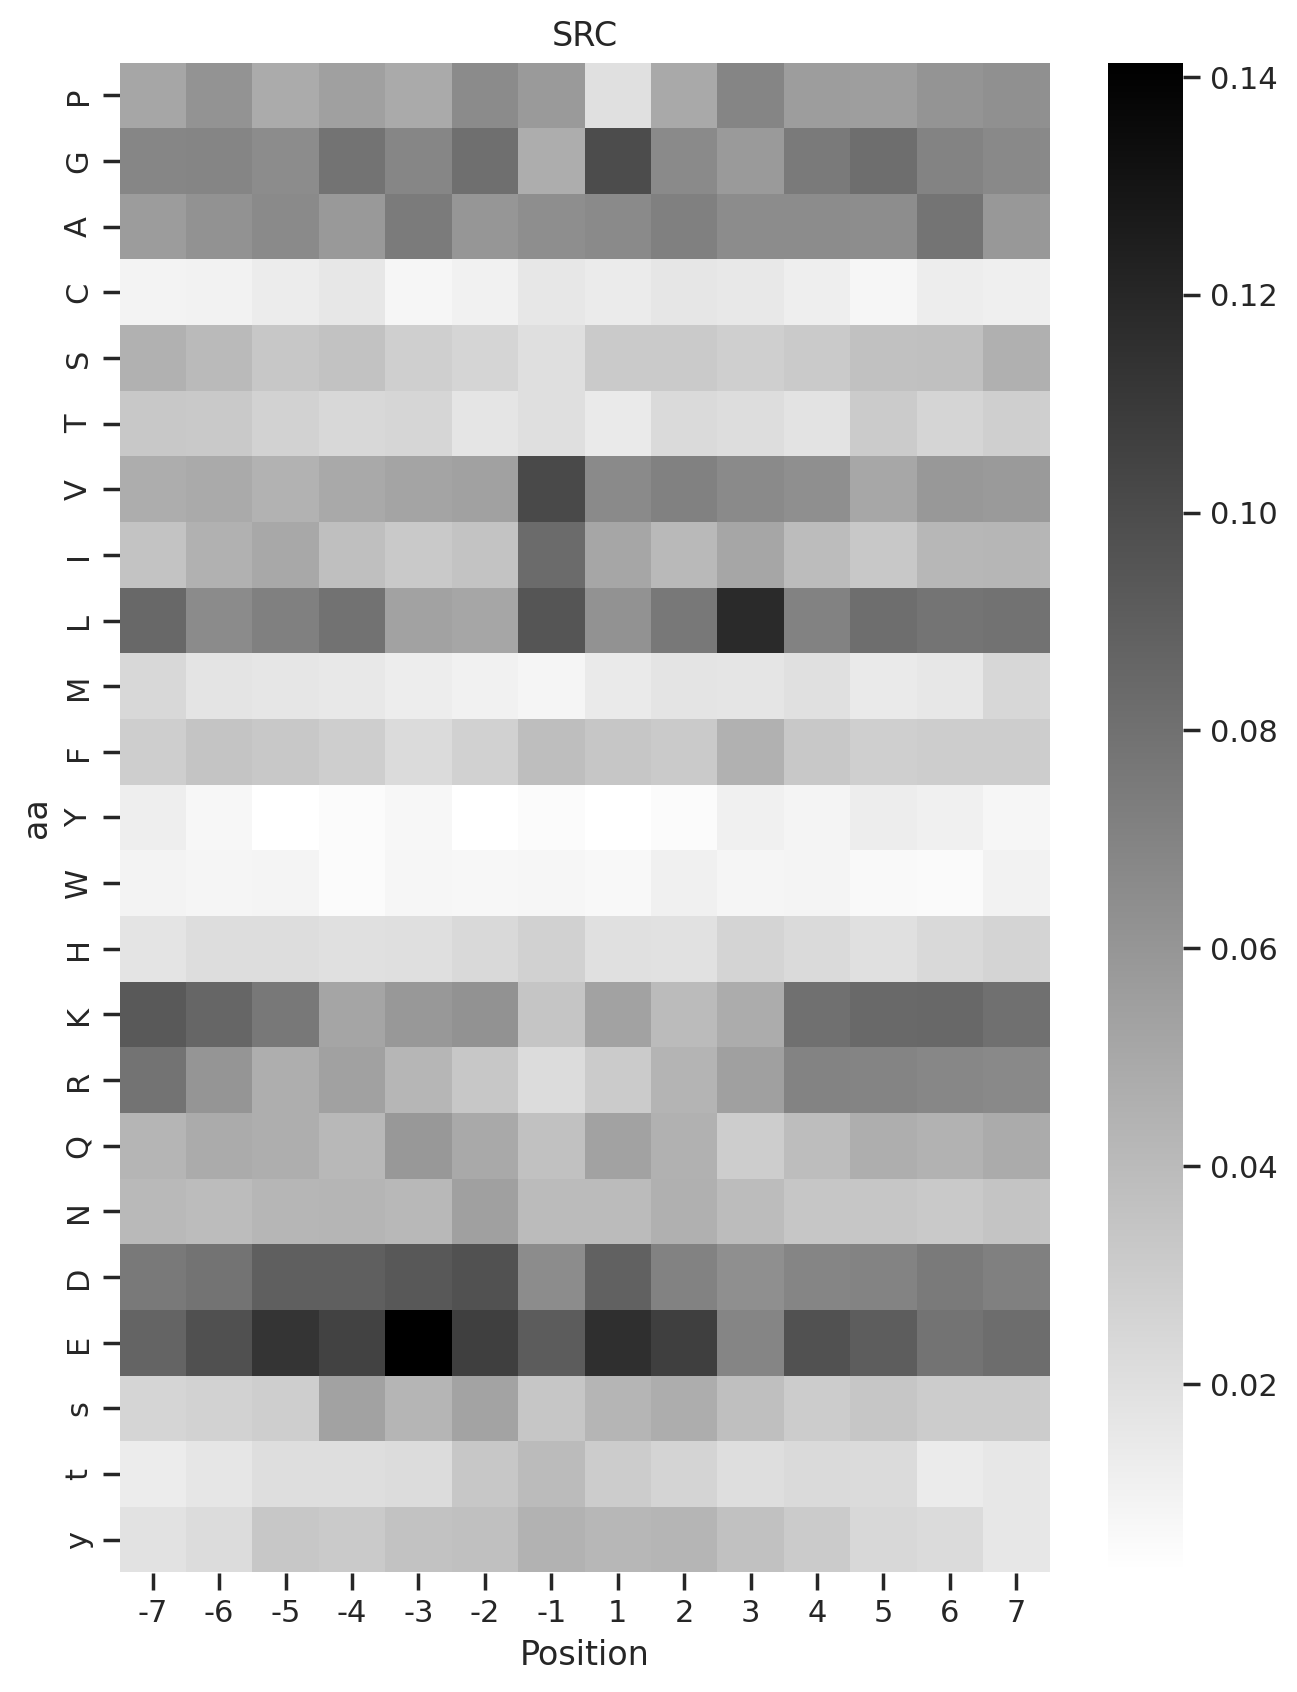

  0%|          | 0/289 [00:01<?, ?it/s]


In [ ]:
for k in tqdm(cnt.index,total=len(cnt)):
    df_k = df.query(f'kinase=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    # fig, axs = plt.subplots(2, 1, figsize=(10, 20))
    
    plot_count(df_k,k)
    # plt.savefig(f'fig/count/{k}.png',bbox_inches='tight', pad_inches=0.1)
    plt.show() # if visualize in jupyter notebook, uncheck the savefig
    plt.close()

    get_logo2(full, k)
    # plt.savefig(f'fig/logo/{k}.png',bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()

    plot_heatmap(full.drop(columns=[0]),k,figsize=(7.5,10))
    # plt.savefig(f'fig/heatmap/{k}.png',bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    break

all

In [ ]:
for k in tqdm(cnt.index,total=len(cnt)):
    df_k = df.query(f'kinase=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    # fig, axs = plt.subplots(2, 1, figsize=(10, 20))
    
    plot_count(df_k,k)
    plt.savefig(f'fig/count/{k}.png',bbox_inches='tight', pad_inches=0.1)
    # plt.show() # if visualize in jupyter notebook, uncheck the savefig
    plt.close()

    get_logo2(full, k)
    plt.savefig(f'fig/logo/{k}.png',bbox_inches='tight', pad_inches=0.3)
    # plt.show()
    plt.close()

    plot_heatmap(full.drop(columns=[0]),k,figsize=(7.5,10))
    plt.savefig(f'fig/heatmap/{k}.png',bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()
    # break

100%|██████████| 289/289 [21:53<00:00,  4.54s/it]


Combine images vertically

In [ ]:
def combine_images_vertically(image_paths, output_path):
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    total_width = max(image.width for image in images)
    total_height = sum(image.height for image in images)

    combined_image = Image.new('RGBA', (total_width, total_height))

    y_offset = 0
    for image in images:
        combined_image.paste(image, (0, y_offset), image)
        y_offset += image.height

    combined_image.save(output_path)

In [ ]:
folders = ["fig/count", "fig/logo", "fig/heatmap"]
for k in tqdm(cnt.index,total=len(cnt)):
    filename = f"{k}.png"
    image_paths = [os.path.join(folder, filename) for folder in folders]
    output_path = f"fig/combine/{k}.png"
    
    combine_images_vertically(image_paths, output_path)
    # break

100%|██████████| 289/289 [03:03<00:00,  1.58it/s]


## Get freq data

In [ ]:
for i,k in enumerate(cnt.index):
    df_k = df.query(f'kinase=="{k}"').reset_index()
    paper,full = get_freq(df_k)

    melt = full.drop(columns = [0]).reset_index().melt(id_vars=['aa'], value_name=k, var_name='Position')
    melt['substrate']=melt['Position'].astype(str)+ melt['aa']

    position_0 = full[0][['s','t','y']].reset_index().rename(columns={0:k})
    position_0['substrate'] = '0'+position_0['aa']

    if i ==0:
        first = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
    else:
        k = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
        data = pd.concat([first,k],axis=1)
        first = data.copy()
    
    # break

In [ ]:
data = data.T

data.index = data.index.rename('kinase')

To save

In [ ]:
# data.to_csv('supp/Fig2_main.csv')

# data.to_parquet('ks_main.parquet')

In [ ]:
data_info = cnt.reset_index(name='count').rename(columns={'index':'kinase'})
data_info = data_info.merge(info)

# data_info.to_parquet('ks_main_info.parquet')

### Get freq that combined s,t,y to S,T,Y

In [ ]:
# List of suffixes
suffixes = ['S', 'T', 'Y']

for suffix in suffixes:
    for i in range(-7, 8):  # looping from -7 to 7
        if i == 0:  # Skip 0
            continue
        
        upper_col = f"{i}{suffix}"  # e.g., -7S
        lower_col = f"{i}{suffix.lower()}"  # e.g., -7s
        data[upper_col] = data[upper_col] + data[lower_col]
        data.drop(lower_col, axis=1,inplace=True)  # Drop the lowercase column after combining

In [ ]:
data.columns[data.columns.str.contains('S')]

Index(['-7S', '-6S', '-5S', '-4S', '-3S', '-2S', '-1S', '1S', '2S', '3S', '4S',
       '5S', '6S', '7S'],
      dtype='object', name='substrate')

In [ ]:
# make sure the "s" in positions other than 0 is deleted from the columns
data.columns[data.columns.str.contains('s')]

Index(['0s'], dtype='object', name='substrate')

In [ ]:
# Make sure very position's sum is 1
data.loc[:,data.columns.str.contains('-7')].sum(1).sort_values()

kinase
MINK     1.0
NLK      1.0
DAPK1    1.0
PLK4     1.0
CHK1     1.0
        ... 
MARK4    1.0
HIPK2    1.0
NEK7     1.0
IKKB     1.0
PKCB     1.0
Length: 289, dtype: float64

In [ ]:
data = data.rename(columns={'0s':'0S','0t':'0T','0y':'0Y'})

In [ ]:
data.index = data.index.rename('kinase')

To save

In [ ]:
# data.to_parquet('ks_main_upper.parquet')
# data.to_csv('main_upper.csv')

## Plot other kinase
> not on tree, (isoforms, mutations, lipid kinase)

In [ ]:
cnt_other = df.query('on_tree==0').kinase.value_counts()

cnt_other = cnt_other[cnt_other>100]

In [ ]:
others = cnt_other.index.tolist()+['LYN','ABL1','RET','FGFR3','PDGFRA','ALK',
                          'EGFR','KIT','MET','PKCB','BRAF','PKG1'] # BRAF is less than 100

Generate logos and heatmaps

One example:

  0%|          | 0/36 [00:00<?, ?it/s]

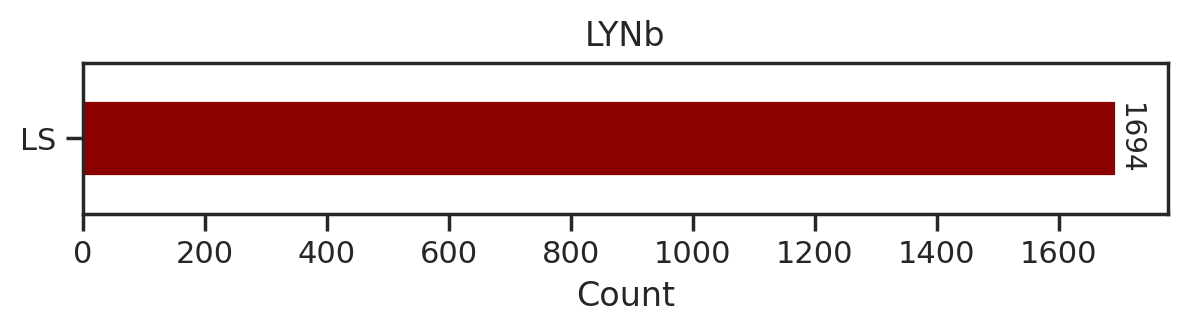

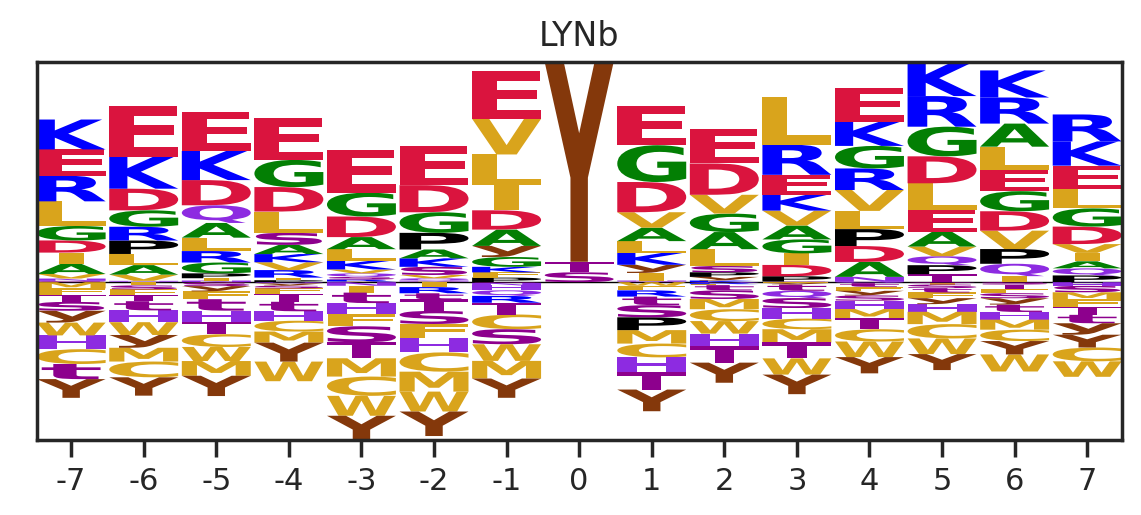

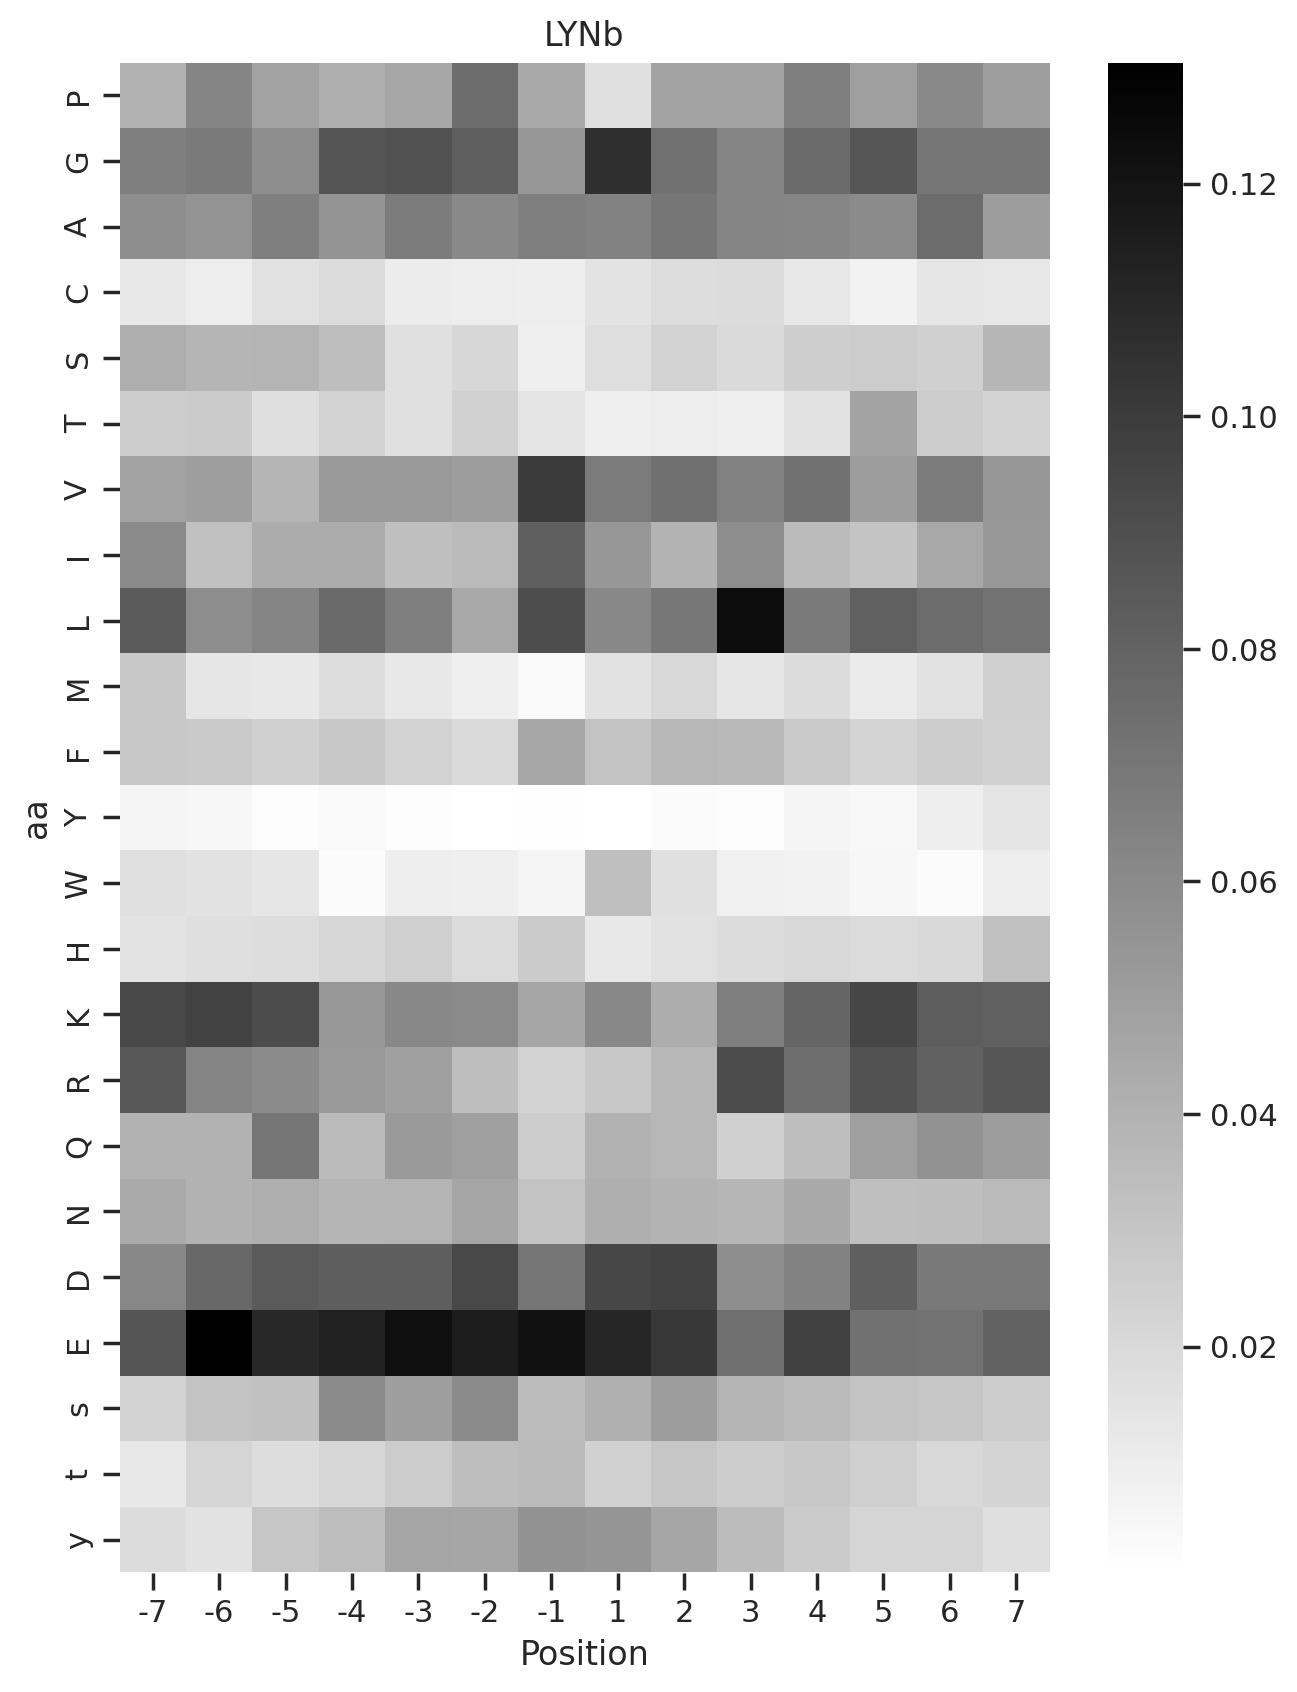

  0%|          | 0/36 [00:03<?, ?it/s]


In [ ]:
for k in tqdm(others,total=len(others)):
    df_k = df.query(f'kinase=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    
    plot_count(df_k,k)
    # plt.savefig(f'fig_others/count/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0.1)
    plt.show() # if visualize in jupyter notebook, uncheck the savefig
    plt.close()
    
    get_logo2(full,k)
    # plt.savefig(f'fig_others/logo/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()
    
    plot_heatmap(full.drop(columns=[0]),k,figsize=(7.5,10))
    # plt.savefig(f'fig_others/heatmap/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    break

all

In [ ]:
for k in tqdm(others,total=len(others)):
    df_k = df.query(f'kinase=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    
    plot_count(df_k,k)
    plt.savefig(f'fig_others/count/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0.1)
    # plt.show() # if visualize in jupyter notebook, uncheck the savefig
    plt.close()
    
    get_logo2(full,k)
    plt.savefig(f'fig_others/logo/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0.3)
    plt.close()
    
    plot_heatmap(full.drop(columns=[0]),k,figsize=(7.5,10))
    plt.savefig(f'fig_others/heatmap/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0)
    plt.close()

100%|██████████| 36/36 [02:24<00:00,  4.01s/it]


Combine the figures

In [ ]:
folders = ["fig_others/count", "fig_others/logo", "fig_others/heatmap"]
for k in tqdm(others,total = len(others)):
    k = k.replace("/", "_")
    
    filename = f"{k}.png"
    
    image_paths = [os.path.join(folder, filename) for folder in folders]
    
    output_path = f"fig_others/combine/{k}.png"
    
    combine_images_vertically(image_paths, output_path)
    # break

100%|██████████| 36/36 [00:19<00:00,  1.81it/s]


Get the freq

In [ ]:
for i,k in enumerate(others):
    df_k = df.query(f'kinase=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    
    melt = full.drop(columns = [0]).reset_index().melt(id_vars=['aa'], value_name=k, var_name='Position')
    melt['substrate']=melt['Position'].astype(str)+ melt['aa']

    position_0 = full[0][['s','t','y']].reset_index().rename(columns={0:k})
    position_0['substrate'] = '0'+position_0['aa']

    if i ==0:
        first = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
    else:
        k = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
        data = pd.concat([first,k],axis=1)
        first = data.copy()

In [ ]:
data = data.T

data.index = data.index.rename('kinase')

In [ ]:
data.to_csv('others.csv')

# data.to_parquet('ks_others.parquet')

In [ ]:
cnt_other2 = df[df.kinase.isin(others)].kinase.value_counts()

data_info = cnt_other2.reset_index(name='count').rename(columns={'index':'kinase'})
# data_info = data_info.merge(info)

In [ ]:
# data_info.to_parquet('ks_others_info.parquet')

In [ ]:
data_info

,kinase,count
0,ALK,1889
1,ABL1,1837
2,RET,1769
3,LYNb,1694
4,MET,1485
5,ABL1[T315I],1320
6,ABL1[E255K],1274
7,LYN,1263
8,RET[M918T],1221
9,FGFR3[K650M],1220
